# Neural style transfer
As part of Fast AI's challenge for students, I will be implementing neural style transfer. Given that I am training primarily on my M1 MacBook Pro's GPU (read: slow training), I may set some aspects to be easier to train (e.g. less epochs, less classes etc).

Let's have a go at it and see what happens.

In [1]:
import shutil,os,torch,random,datasets,math
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision import transforms
from torchvision.io import read_image,ImageReadMode
from glob import glob
from sklearn.model_selection import train_test_split
from IPython.display import display

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [2]:
from PIL import Image

In [3]:
from fastprogress import progress_bar

In [4]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

In [5]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'tiny-best-artwork'

We need to split our data into train test folders.

In [6]:
data_prepped = True

In [7]:
if not data_prepped:
    for artist_folder in path.iterdir():
        if artist_folder.is_dir():
            files = list(glob(str(artist_folder/'*.jpg')))
            train_files, test_files = train_test_split(files, test_size=0.2)

            # Create `train` and `test` folders
            train_folder = artist_folder / 'train'
            test_folder = artist_folder / 'test'
            os.makedirs(train_folder, exist_ok=True)
            os.makedirs(test_folder, exist_ok=True)

            # Move files to `train` folder
            for train_file in train_files:
                shutil.move(train_file, train_folder / os.path.basename(train_file))

            # Move files to `test` folder
            for test_file in test_files:
                shutil.move(test_file, test_folder / os.path.basename(test_file))


In [8]:
bs = 128

### Prep `train_ds` and `val_ds`

In [9]:
class TinyDS:
    def __init__(self, path, train_or_test):
        self.path = Path(path)
        self.files = glob(str(self.path/f"*/{train_or_test}/*.jpg"), recursive=True)

    def __len__(self): return len(self.files)

    def __getitem__(self, i):
        return self.files[i], Path(self.files[i]).parent.parent.name

In [10]:
train_ds = TinyDS(path, "train")

In [11]:
len(train_ds)

1104

In [12]:
train_ds[0]

('data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_14.jpg',
 'Albrecht_Du╠êrer')

In [13]:
train_ds[10]

('data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_118.jpg',
 'Albrecht_Du╠êrer')

In [14]:
val_ds = TinyDS(path, "test")

In [15]:
len(val_ds)

279

In [16]:
val_ds[0]

('data/tiny-best-artwork/Albrecht_Du╠êrer/test/Albrecht_Du╠êrer_247.jpg',
 'Albrecht_Du╠êrer')

In [17]:
val_ds[30]

('data/tiny-best-artwork/Albrecht_Du╠êrer/test/Albrecht_Du╠êrer_237.jpg',
 'Albrecht_Du╠êrer')

### Make sure images are read correctly

In [18]:
img = Image.open("data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_14.jpg")


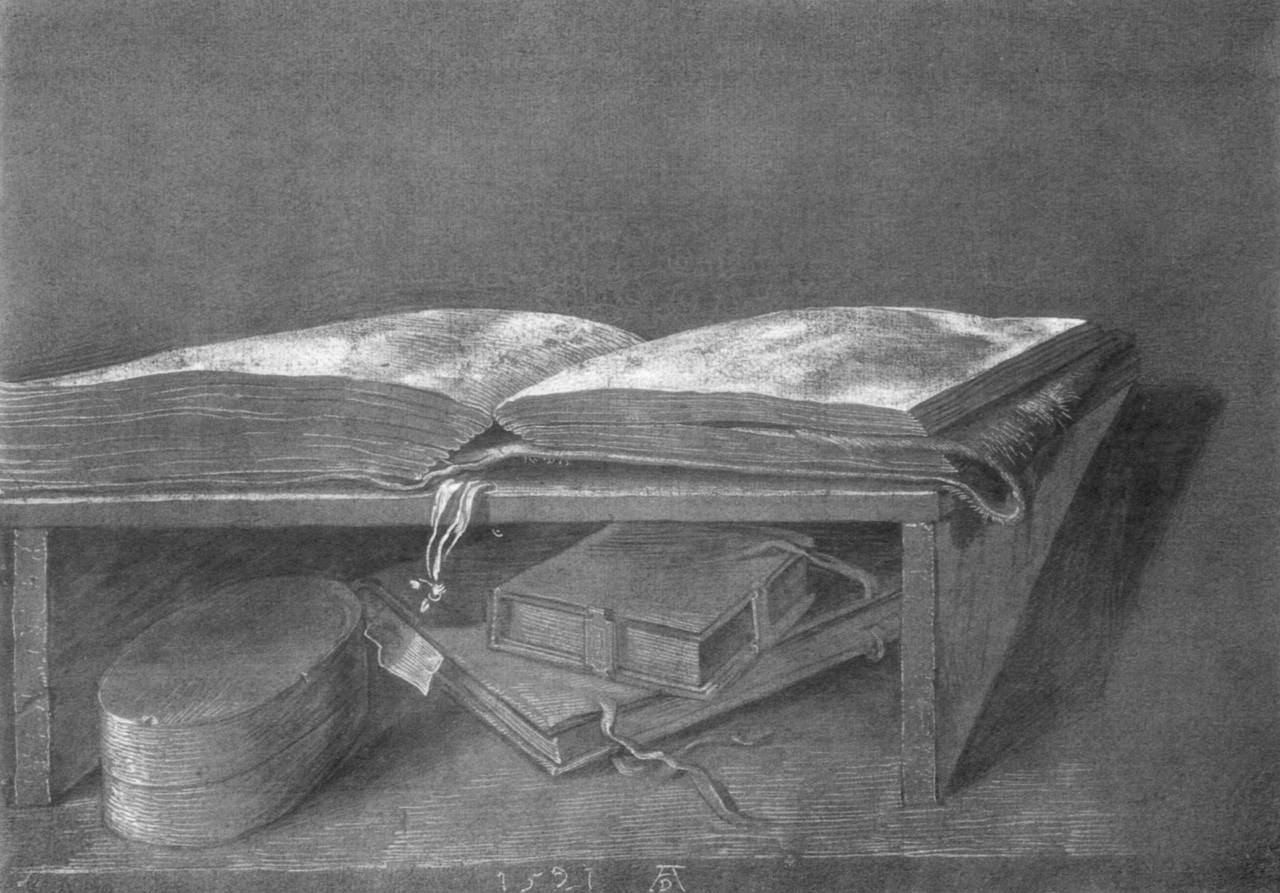

In [19]:
display(img)

In [20]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])
img_t = transform(img)
img_t.shape

torch.Size([3, 64, 64])

<Axes: >

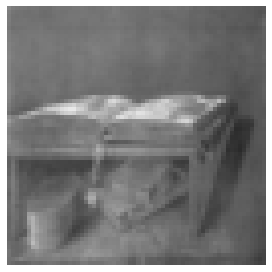

In [21]:
show_image(img_t)

Oddly enough, this looks ok too.

### Normalise/standardise images

In [22]:
train_tensor_list = []

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

for img_path, _ in train_ds:
    img = Image.open(img_path)
    img_t = transform(img)
    if img_t.shape != torch.Size([3, 64, 64]):
        os.remove(img_path)
        print(f"Removed {img_path}")
        continue
    train_tensor_list.append(img_t)

stacked_train_tensors = torch.stack(train_tensor_list, dim=0)
x_mean = torch.mean(stacked_train_tensors, dim=(0,2,3))
x_std = torch.std(stacked_train_tensors, dim=(0,2,3))

x_mean, x_std

(tensor([0.60313, 0.56858, 0.53134]), tensor([0.23981, 0.24546, 0.26040]))

In [23]:
for img_path, _ in val_ds:
    img = Image.open(img_path)
    img_t = transform(img)
    if img_t.shape != torch.Size([3, 64, 64]):
        os.remove(img_path)
        print(f"Removed {img_path}")
        continue

In [24]:
img_t - x_mean[:,None,None]

tensor([[[ 0.08707,  0.06354,  0.06354,  ...,  0.05570,  0.05962,  0.09883],
         [ 0.07138,  0.06354,  0.07530,  ...,  0.08315,  0.08707,  0.08707],
         [ 0.06746,  0.08315,  0.07923,  ...,  0.11060,  0.06354,  0.06746],
         ...,
         [ 0.13805,  0.12628,  0.08707,  ...,  0.19295,  0.18511,  0.18511],
         [ 0.14981,  0.17727,  0.15374,  ...,  0.20079,  0.21256,  0.22825],
         [ 0.16550,  0.19687,  0.19295,  ...,  0.21648,  0.22432,  0.23609]],

        [[-0.02741, -0.08231, -0.08231,  ..., -0.12937, -0.11368, -0.07839],
         [-0.05878, -0.08623, -0.09015,  ..., -0.10584, -0.09015, -0.09407],
         [-0.07054, -0.07447, -0.09015,  ..., -0.07447, -0.12937, -0.12937],
         ...,
         [-0.00388, -0.03525, -0.10976,  ..., -0.01564, -0.01172, -0.00388],
         [ 0.02749,  0.05495, -0.00780,  ...,  0.01181,  0.03534,  0.05887],
         [ 0.05887,  0.09024,  0.06279,  ...,  0.03926,  0.05887,  0.07847]],

        [[-0.18232, -0.23330, -0.24114,  ...

In [25]:
def tfmx(x):
    img = Image.open(x)
    transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        # transforms.Normalize(x_mean[:,None,None], x_std[:,None,None]),
    ])
    img_t = transform(img)
    return img_t


In [26]:
str2id = {
    "Albrecht_Du╠êrer": 0,
    "Albrecht_Dürer": 1,
    "Alfred_Sisley": 2,
    "Amedeo_Modigliani": 3,
    "Andrei_Rublev": 4,
    "Andy_Warhol": 5,
}

In [27]:
id2str = {v:k for k,v in str2id.items()}

In [28]:
def tfmy(y): return tensor(str2id[y])

In [29]:
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return self.tfmx(x),self.tfmy(y)

In [30]:
tfm_tds = TfmDS(train_ds, tfmx, tfmy)
tfm_vds = TfmDS(val_ds, tfmx, tfmy)

In [31]:
x0, y0 = tfm_tds[0]
x0, y0

(tensor([[[0.52549, 0.48627, 0.47451,  ..., 0.34118, 0.33725, 0.34510],
          [0.49412, 0.45882, 0.44706,  ..., 0.33725, 0.32549, 0.33725],
          [0.48235, 0.44706, 0.43922,  ..., 0.33725, 0.33333, 0.36471],
          ...,
          [0.45098, 0.40784, 0.40784,  ..., 0.28235, 0.25882, 0.26275],
          [0.43922, 0.44706, 0.47059,  ..., 0.25490, 0.23529, 0.25882],
          [0.43137, 0.41176, 0.39216,  ..., 0.27059, 0.25490, 0.26667]],
 
         [[0.52549, 0.48627, 0.47451,  ..., 0.34118, 0.33725, 0.34510],
          [0.49412, 0.45882, 0.44706,  ..., 0.33725, 0.32549, 0.33725],
          [0.48235, 0.44706, 0.43922,  ..., 0.33725, 0.33333, 0.36471],
          ...,
          [0.45098, 0.40784, 0.40784,  ..., 0.28235, 0.25882, 0.26275],
          [0.43922, 0.44706, 0.47059,  ..., 0.25490, 0.23529, 0.25882],
          [0.43137, 0.41176, 0.39216,  ..., 0.27059, 0.25490, 0.26667]],
 
         [[0.52549, 0.48627, 0.47451,  ..., 0.34118, 0.33725, 0.34510],
          [0.49412, 0.45882,

In [32]:
x1, y1 = tfm_tds[1]
x1, y1

(tensor([[[0.99216, 0.98039, 0.97255,  ..., 0.88235, 0.90196, 0.98824],
          [0.98431, 0.81961, 0.83529,  ..., 0.47843, 0.42353, 0.87843],
          [0.98039, 0.86275, 0.86275,  ..., 0.43922, 0.34118, 0.77647],
          ...,
          [0.86667, 0.71373, 0.64706,  ..., 0.57647, 0.77255, 0.96863],
          [0.85490, 0.66275, 0.68627,  ..., 0.55686, 0.74510, 0.96471],
          [0.95686, 0.91765, 0.91765,  ..., 0.76863, 0.82745, 0.97255]],
 
         [[0.99216, 0.98039, 0.97255,  ..., 0.88235, 0.90196, 0.98824],
          [0.98431, 0.81961, 0.83529,  ..., 0.47843, 0.42353, 0.87843],
          [0.98039, 0.86275, 0.86275,  ..., 0.43922, 0.34118, 0.77647],
          ...,
          [0.86667, 0.71373, 0.64706,  ..., 0.57647, 0.77255, 0.96863],
          [0.85490, 0.66275, 0.68627,  ..., 0.55686, 0.74510, 0.96471],
          [0.95686, 0.91765, 0.91765,  ..., 0.76863, 0.82745, 0.97255]],
 
         [[0.99216, 0.98039, 0.97255,  ..., 0.88235, 0.90196, 0.98824],
          [0.98431, 0.81961,

In [33]:
train_ds[0]

('data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_14.jpg',
 'Albrecht_Du╠êrer')

In [34]:
train_ds[1]

('data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_253.jpg',
 'Albrecht_Du╠êrer')

<Axes: >

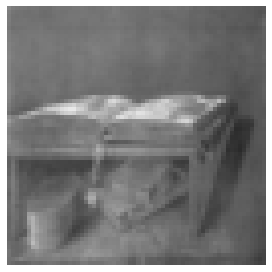

In [35]:
show_image(x0)

In [36]:
torch.max(x0)

tensor(0.90980)

In [37]:
torch.min(x0)

tensor(0.16471)

Because standardisation skews the min/max pixel values to be (imo) not within the same range (-2 to 1), I've decided to put aside standardisation first and try it out later if necessary.

### DataLoaders

In [38]:
train_dl = DataLoader(tfm_tds, batch_size=bs, shuffle=True, num_workers=0)
valid_dl = DataLoader(tfm_vds, batch_size=bs, shuffle=False, num_workers=0)

In [39]:
xb, yb = b = next(iter(train_dl))

In [40]:
len(xb)

128

In [41]:
titles = [id2str[int(o)] for o in yb]
', '.join(titles[:16])

'Andy_Warhol, Albrecht_Du╠êrer, Andrei_Rublev, Amedeo_Modigliani, Andrei_Rublev, Albrecht_Dürer, Amedeo_Modigliani, Albrecht_Du╠êrer, Alfred_Sisley, Amedeo_Modigliani, Alfred_Sisley, Alfred_Sisley, Albrecht_Dürer, Alfred_Sisley, Andrei_Rublev, Albrecht_Du╠êrer'

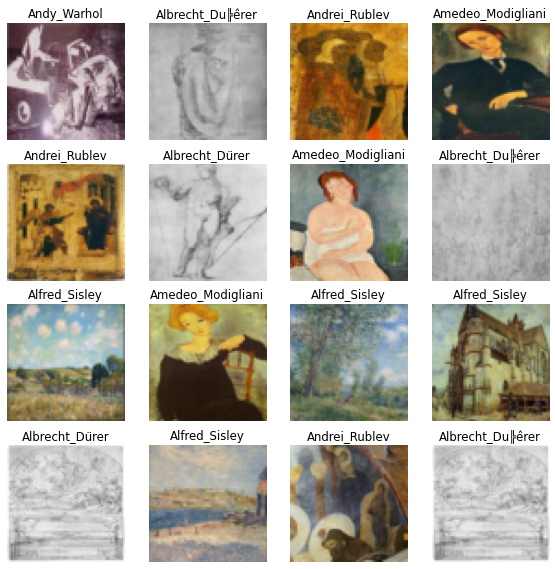

In [42]:
show_images(xb[:16], titles=titles[:16], imsize=2.5)

In [43]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=1))

## Basic Model

In [44]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [45]:
nfs = (8, 16, 32, 64, 128, 256)

In [46]:
def get_dropmodel(act=act_gr, nfs=nfs, norm=nn.BatchNorm2d, drop=0.1):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    #layers += [nn.Linear(nfs[-1], 6, bias=False), nn.BatchNorm1d(6)]
    layers += [nn.Linear(nfs[-1], 64, bias=True), 
               nn.Linear(64, 16, bias=True),
               nn.Linear(16, 6, bias=False),
               nn.BatchNorm1d(6)]
    return nn.Sequential(*layers).apply(iw).to(def_device)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


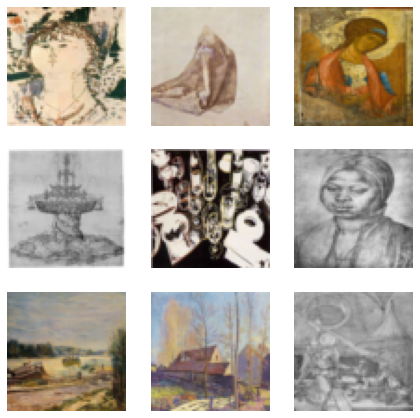

In [47]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(xb.cpu()[:9], imsize=2.5)

In [48]:
learn.summary()

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Tot params: 1227772; MFLOPS: 20.8


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Conv2d|(128, 3, 64, 64)|(128, 8, 64, 64)|608|2.5|
|ResBlock|(128, 8, 64, 64)|(128, 16, 32, 32)|3696|3.7|
|ResBlock|(128, 16, 32, 32)|(128, 32, 16, 16)|14560|3.7|
|ResBlock|(128, 32, 16, 16)|(128, 64, 8, 8)|57792|3.7|
|ResBlock|(128, 64, 8, 8)|(128, 128, 4, 4)|230272|3.7|
|ResBlock|(128, 128, 4, 4)|(128, 256, 2, 2)|919296|3.7|
|AdaptiveAvgPool2d|(128, 256, 2, 2)|(128, 256, 1, 1)|0|0.0|
|Flatten|(128, 256, 1, 1)|(128, 256)|0|0.0|
|Dropout|(128, 256)|(128, 256)|0|0.0|
|Linear|(128, 256)|(128, 6)|1536|0.0|
|BatchNorm1d|(128, 6)|(128, 6)|12|0.0|


In [49]:
opt_func = partial(optim.AdamW, eps=1e-5)

In [50]:
lr_cbs = [DeviceCB(), ProgressCB()]

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started 

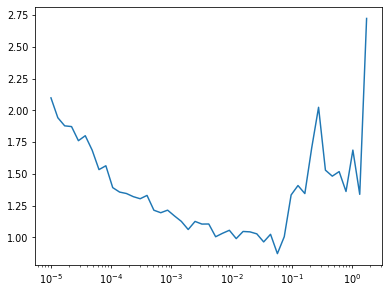

In [51]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
learn.lr_find()

In [52]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

In [55]:
epochs=25
lr=1e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs, opt_func=opt_func)

accuracy,loss,epoch,train
0.487,1.321,0,train
0.269,2.044,0,eval
0.636,0.979,1,train
0.254,2.240,1,eval
0.683,0.875,2,train
0.563,1.075,2,eval
0.722,0.795,3,train
0.398,1.439,3,eval
0.745,0.758,4,train
0.448,1.298,4,eval


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


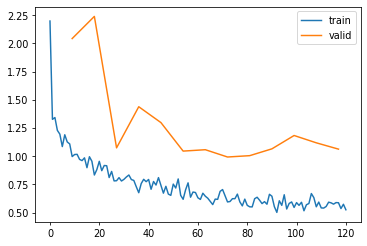

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started 

In [56]:
learn.fit(epochs)